# Исследование данных сервиса аренды самокатов GoFast.

## План исследования:
    
    1) Загрузить и изучить данные о пользователях из разных городов и их поездках.
    2) Выполнить предобработку данных. Найти и обработать пропуски и дубли в датафреймах. 
    3) Провести исследовательский анализ данных, описать и визуализировать общую информацию о пользователях и поездках.
    4) Объеденить данные в один датафрейм и визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.
    5) Рассчитать суммарную выручку по месяцам по каждому пользователю.
    6) Провести проверку ряда гипотез. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

## Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


1565 строк в датафрейме users, без пропусков, указанные типы данных в столбцах соответствуют находящимся в них данным. Ничего менять не нужно.

In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


18068 строк в датафрейме rides. Без пропусков. В столбце date находятся данные, с типом object. Далее изменим тип данных на datetime.

In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


## Предобработка данных

Изменим тип данных в датафрейме rides в столбце date на datetime, чтобы мы могли работать с ним, как с датами. 

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Создадим новый стоблец month в датафрейме rides с номером месяца в соответствии с информацией из столбца date. И проверим датафрейм.

In [10]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверим данные на присутствие полных дубликатов и удалим их в случае нахождения. 

In [11]:
print('Количество дубликатов в датафрейме users:', users.duplicated().sum())
print('Количество дубликатов в датафрейме rides:', rides.duplicated().sum())

Количество дубликатов в датафрейме users: 31
Количество дубликатов в датафрейме rides: 0


In [12]:
users = users.drop_duplicates().reset_index(drop= True)
print('Количество дубликатов в датафрейме users:', users.duplicated().sum())
print('Количество дубликатов в датафрейме rides:', rides.duplicated().sum())

Количество дубликатов в датафрейме users: 0
Количество дубликатов в датафрейме rides: 0


## Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках:

### Частота встречаемости городов;

In [13]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

<AxesSubplot:title={'center':'Количество пользователей по городам'}, ylabel='Города'>

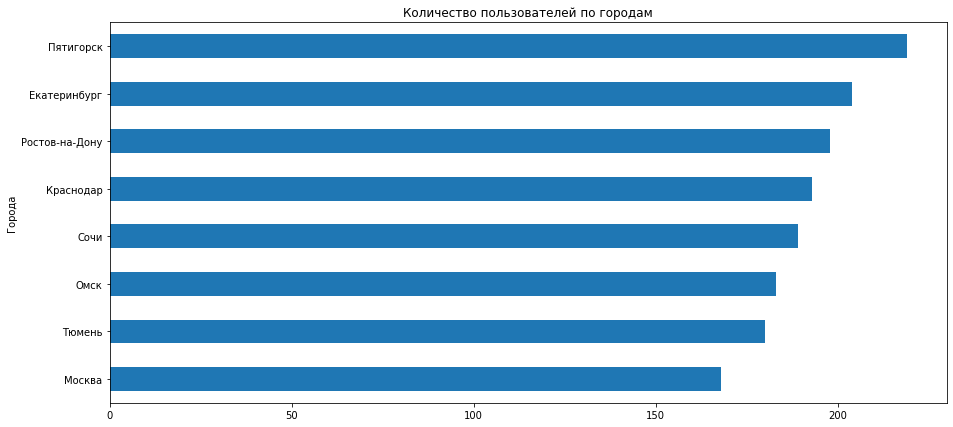

In [14]:
users.groupby('city')['city'].count().sort_values().plot(
    kind='barh',figsize=(15,7), title='Количество пользователей по городам', 
    xlabel='Города')

В датафрейме users представленны пользователи из 8 городов, максимальное количество, 219 из Пятигорска, минимальное, 168, из Москвы. 

### Соотношение пользователей с подпиской и без подписки;

<AxesSubplot:title={'center':'Соотношение пользователей с подпиской и без подписки'}, ylabel='название подписки'>

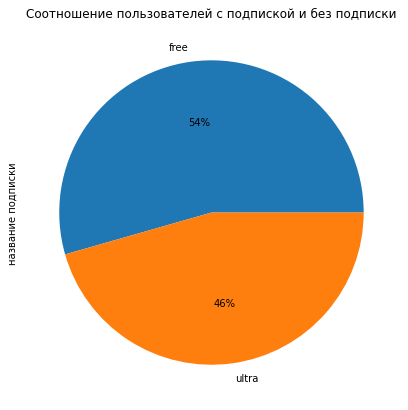

In [15]:
users.groupby('subscription_type')['subscription_type'].count().plot(
    kind='pie',figsize=(15,7), 
    autopct='%1.0f%%', 
    title='Соотношение пользователей с подпиской и без подписки', 
    ylabel='название подписки')

Пользователи соотносятся в процентном соотношении 54/46% с бесплатной и платной подписками соответственно. Количество пользователей на бесплатной подписке больше на 8%. 

### Возраст пользователей


Text(0, 0.5, 'Количество')

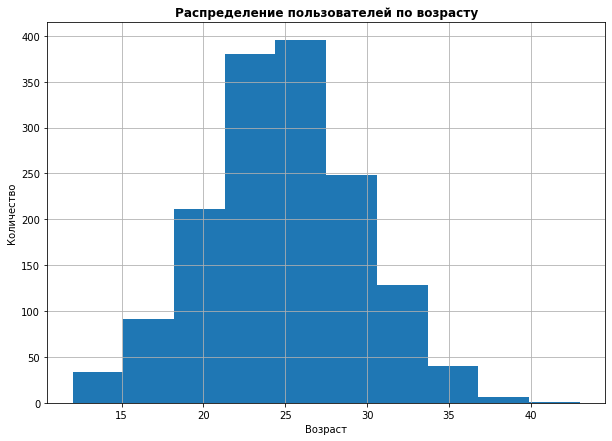

In [16]:
age = users['age'].hist(bins=10, figsize=(10,7))
age.set_title('Распределение пользователей по возрасту',
             weight='bold')
age.set_xlabel('Возраст')
age.set_ylabel('Количество')

In [17]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Возраст большей части пользователей распределен в интервале от 22 до 28 лет. Средний возраст ~ 25 лет. Минимальный 12, максимальный 43 года. 

### Расстояние, которое пользователь преодолел за одну поездку

Text(0, 0.5, 'Количество')

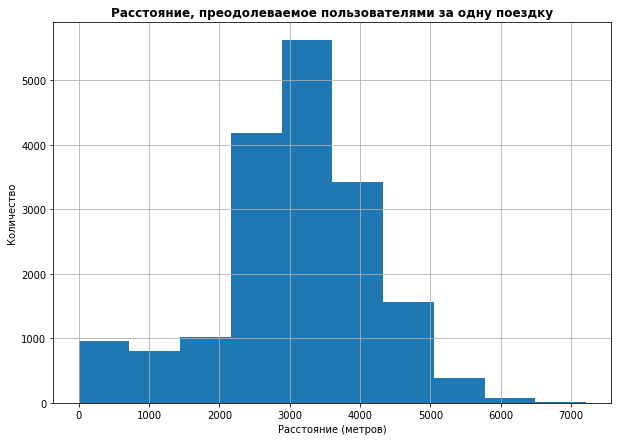

In [18]:
dist = rides['distance'].hist(bins=10, figsize=(10,7))
dist.set_title('Расстояние, преодолеваемое пользователями за одну поездку',
             weight='bold')
dist.set_xlabel('Расстояние (метров)')
dist.set_ylabel('Количество')

In [19]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Среднее расстояние, которое преодолели пользователи составляет 3070 м. Что практически совпадает с медианой (3133 м). 
50% всех пользователей преодолели расстояние от 2500 до 3800 м. 

### Продолжительность поездок


Text(0, 0.5, 'Количество')

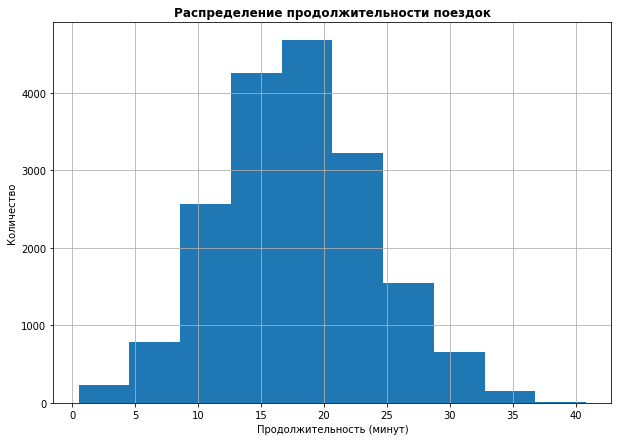

In [20]:
dur = rides['duration'].hist(bins=10, figsize=(10,7))
dur.set_title('Распределение продолжительности поездок',
             weight='bold')
dur.set_xlabel('Продолжительность (минут)')
dur.set_ylabel('Количество')

In [21]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее время поездки также практически равно медиане и составляет 17,8 минут. 
50% пользователей совершили поездки продолжительностью от 13,5 до 22 минут. 

## Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм

In [22]:
df = users.merge(rides, on='user_id', how='left')
df


,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


In [23]:
print('Строк в старом датафрейме:', len(rides))
print('Строк в новом датафрейме:', len(df))
print('Количество пропусков в новом датафрейме:'   , df.isna().sum())

Строк в старом датафрейме: 18068
Строк в новом датафрейме: 18068
Количество пропусков в новом датафрейме: user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64


Создадим датафрейм df_free, где будут только пользователи без подписки

In [24]:
df_free = df[df['subscription_type'] == 'free'].reset_index(drop= True)
df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2


Посмотрим на среднюю продолжительность поездки и расстояние пользователей без подписки:

array([[<AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

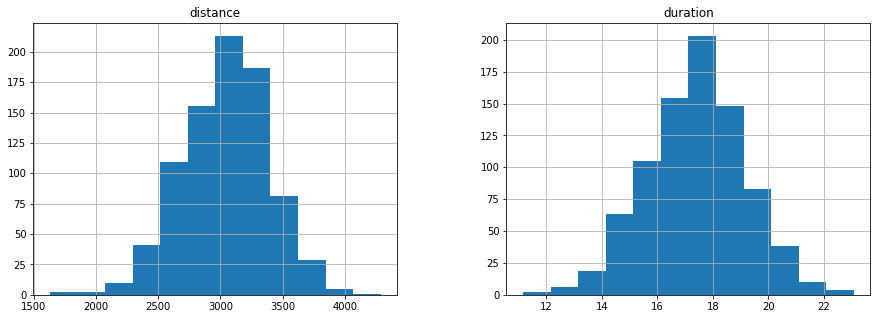

In [25]:
stat_free = pd.pivot_table(df_free, index=['user_id'], values=['distance', 'duration'])
stat_free.hist(bins=12, figsize=(15,5))

In [26]:
stat_free.describe()

,distance,duration
count,835.000000,835.000000
mean,3047.023441,17.384033
std,346.570021,1.759845
min,1630.788427,11.163431
25%,2820.516763,16.209124
50%,3057.940909,17.402644
75%,3276.990199,18.568622
max,4287.519387,23.069943


Посмотрим на суммарную продолжительность поездок и расстояние пользователей без подписки:

array([[<AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

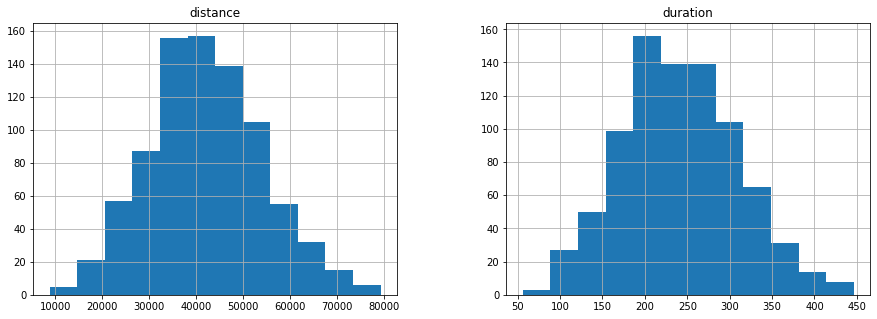

In [27]:
stat_free_sum = pd.pivot_table(df_free, index=['user_id'], values=['distance', 'duration'], aggfunc = ('sum'))
stat_free_sum.hist(bins=12, figsize=(15,5))

In [28]:
stat_free_sum.describe()

,distance,duration
count,835.000000,835.000000
mean,42191.963375,240.931783
std,12106.720431,68.753039
min,8838.803579,56.074907
25%,34183.421552,194.291257
50%,41620.449333,235.716318
75%,50120.358053,286.321154
max,79325.846482,446.233013


Создадим датафрейм df_ultra, где будут только пользователи с подпиской

In [29]:
df_ultra = df[df['subscription_type'] == 'ultra'].reset_index(drop= True)
df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


Посмотрим на среднюю продолжительность поездки и расстояние пользователей с подпиской:

array([[<AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

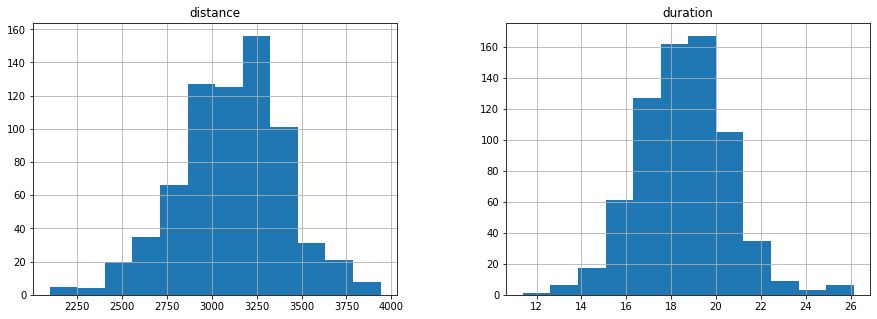

In [30]:
stat_ultra = pd.pivot_table(df_ultra, index=['user_id'], values=['distance', 'duration'])
stat_ultra.hist(bins=12, figsize=(15,5))

In [31]:
stat_ultra.describe()

,distance,duration
count,699.000000,699.000000
mean,3113.459926,18.574380
std,299.706136,2.015094
min,2098.297845,11.385922
25%,2925.005435,17.278630
50%,3134.349186,18.585189
75%,3312.191643,19.789236
max,3939.773328,26.136000


Посмотрим на суммарную продолжительность поездок и расстояние пользователей с подпиской:

array([[<AxesSubplot:title={'center':'distance'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

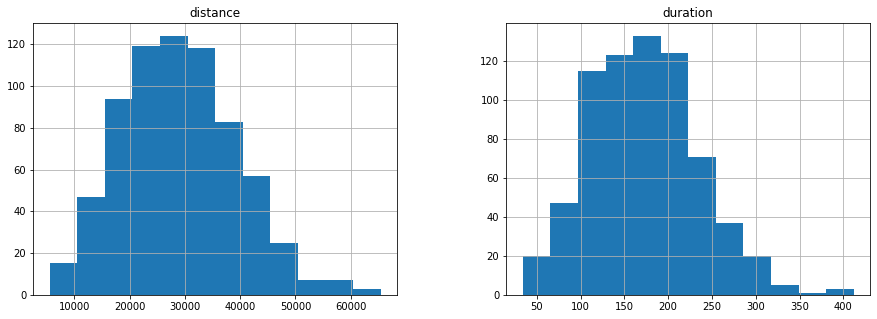

In [32]:
stat_ultra_sum = pd.pivot_table(df_ultra, index=['user_id'], values=['distance', 'duration'], aggfunc = ('sum'))
stat_ultra_sum.hist(bins=12, figsize=(15,5))

In [33]:
stat_ultra_sum.describe()

,distance,duration
count,699.000000,699.000000
mean,28970.522206,172.421894
std,10370.610254,61.061422
min,5530.344048,34.157765
25%,21411.243798,126.094588
50%,28630.341916,169.739505
75%,35708.654860,209.445901
max,65393.983354,411.822515


**Вывод** <br>
Если рассматривать по отдельности каждую поездку, то мы можем увидеть, что пользователи БЕЗ подписки в среднем проезжали расстояние 3050 м. Тогда как пользователи С подпиской 3113 м. 
По времени: 17.4 минуты и 18.6 соответственно.

Пользователи с подпиской в среднем проезжали чуть большее расстояние на 63 метра и совершали поездки длиннее на 1,2 минуты. 
Если рассмотреть общее расстояние и время поездок, которые совершил каждый пользователь сервиса, то увидим, что средний пользователь БЕЗ подписки проехал расстояние в 42,2 км, тогда как С подпиской только 29 км. В среднем пользователь БЕЗ подписки проехал суммарно 241 минуту, а пользователь С подпиской 172 минуты. 
В среднем суммарно пользователи без подписки проезжают большее расстояние и тратят на поездки больше времени, чем пользователи с подпиской. Это мы ещё раз проверим далее статистическими тестами.


## Подсчёт выручки

Округлим продолжительность поездок в датафрейме df в большую сторону до ближайшего целого числа

In [34]:
df['duration'] = np.ceil(df['duration'])
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8


Создадим сводную таблицу по каждому клиенту с суммарной продолжительностью поездки и расстоянием за каждый месяц.

In [35]:
stat_new = pd.pivot_table(df, index=['user_id', 'month', 'subscription_type'], values = ['distance', 'duration'], aggfunc = {'distance': ['sum'],
        'duration' : ['sum', 'count']}).reset_index()
stat_new.columns = ['_'.join(col) for col in stat_new.columns] # избавимся от мультииндекса
stat_new.head()

,user_id_,month_,subscription_type_,distance_sum,duration_count,duration_sum
0,1,1,ultra,7027.511294,2,42.0
1,1,4,ultra,754.159807,1,7.0
2,1,8,ultra,6723.470560,2,46.0
3,1,10,ultra,5809.911100,2,32.0
4,1,11,ultra,7003.499363,3,56.0


In [36]:
# функция для расчёта выручки за поездки
def income(row):
    if row['subscription_type_'] == 'ultra':
        total_income = (row['duration_count']*subscriptions.loc[1,'start_ride_price'] +
                        row['duration_sum']*subscriptions.loc[1,'minute_price'] +
                        subscriptions.loc[1,'subscription_fee'])
    if row['subscription_type_'] == 'free':
         total_income = (row['duration_count']*subscriptions.loc[0,'start_ride_price'] +
                        row['duration_sum']*subscriptions.loc[0,'minute_price'] +
                        subscriptions.loc[0,'subscription_fee'])               
                        
    return total_income

Применим к датафрейму функцию, которая на входе возьмёт строку и в зависимости от типа подписки рассчитает выручку 

In [37]:
stat_new['income'] = stat_new.apply(income, axis=1)
stat_new.head()

,user_id_,month_,subscription_type_,distance_sum,duration_count,duration_sum,income
0,1,1,ultra,7027.511294,2,42.0,451.0
1,1,4,ultra,754.159807,1,7.0,241.0
2,1,8,ultra,6723.470560,2,46.0,475.0
3,1,10,ultra,5809.911100,2,32.0,391.0
4,1,11,ultra,7003.499363,3,56.0,535.0


## Проверка гипотез

### Проверим гипотезу, что пользователи с подпиской тратят больше времени на поездки.

Нулевая гипотеза состоит в том, что пользователи с подпиской тратят столько же времени, сколько и пользователи без подписки.
Альтернативная гипотеза: пользователи с подпиской тратят больше времени, чем пользователи без подписки

In [38]:
# Проведём статистический тест для проверки гипотезы. 

alpha = 0.05

results = st.ttest_ind(stat_ultra['duration'], stat_free['duration'], alternative = 'greater', equal_var=False) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 6.557938251588043e-33
Отвергаем нулевую гипотезу


Среднее время, которое тратят пользователи с подпиской больше, чем пользователи без подписки

### Проверим гипотезу, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Нулевая гипотеза будет состоять в том, что среднее расстояние за одну поездку меньше или равно 3130 метров
Альтернативная гипотеза: среднее расстояние больше 3130 метров. 

In [39]:
interested_value = 3130

alpha = 0.05

results = st.ttest_1samp(
    stat_ultra['distance'], 
    interested_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha :
    print('Отвергаем нулевую гипотезу, среднее расстояние больше, чем 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу, среднее расстояние не превышает 3130 метров')

p-значение: 0.9275041260050892
Не получилось отвергнуть нулевую гипотезу, среднее расстояние не превышает 3130 метров


С точки зрения износа самокатов у нас всё прекрасно и среднее расстояние поездки не превышает 3130 м.

### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нулевая гипотеза: помесячная выручка от пользователей с подпиской равна помесячной выручке пользователей без подписки.
Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

In [40]:
# Проведём статистический тест для проверки гипотезы. 

alpha = 0.05

results = st.ttest_ind(
    stat_new[stat_new['subscription_type_']=='ultra']['income'], 
    stat_new[stat_new['subscription_type_']=='free']['income'], 
    alternative = 'greater', 
    equal_var=False) 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Тест показал, что подтвердилась альтернативная гипотеза, что выручка от пользователей с подпиской выше, чем от пользователей без подписки.

## Вывод

*В данном исследовании были изучены данные о пользователях сервиса аренды самокатов GoFast*

**1)** Выполнена предобработка данных, пропуски отсутствовали, найдены и обработанны дубли в датафреймах. 
Количество дубликатов - 31. 

**2)** Проведён исследовательский анализ данных. <br>
Данные показывают, что в датафрейме представленны пользователи из 8 городов, максимальное количество, 219 из Пятигорска, минимальное, 168, из Москвы.<br>
Пользователи соотносятся в процентном соотношении 54/46% с бесплатной и платной подписками соответственно. Количество пользователей на бесплатной подписке больше на 8%.<br>
Типичный пользователь сервиса имеет возраст от 22 до 28 лет. Средний возраст ~ 25 лет. Минимальный 12, максимальный 43 года. 
Среднее расстояние, которое преодолели пользователи составляет 3070 м. Типичный пользователь преодолевает расстояние от 2500 до 3800 м.<br>
Среднее время поездки составляет 17,8 минут. Большинство пользователей совершили поездки продолжительностью от 13,5 до 22 минут.

**3)** Были сравнены пользователи с подпиской и без. <br>
Если рассматривать по отдельности каждую поездку, то мы можем увидеть, что пользователи БЕЗ подписки в среднем проезжали расстояние 3050 м. Тогда как пользователи С подпиской 3113 м. <br>
По времени: 17.4 минуты и 18.6 соответственно. Пользователи с подпиской в среднем проезжали чуть большее расстояние на 63 метра и совершали поездки длиннее на 1,2 минуты.

**4)** Проверили гипотезу, что пользователи с подпиской тратят больше времени на поездки. Она подтвердилась. Среднее время, которое тратят пользователи с подпиской больше, чем пользователи без подписки.

**5)** Проверили гипотезу, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров. Гипотеза подтвердилась. Среднее расстояние поездки не превышает 3130 м и это оптимально с точки зрения износа самокатов.

**6)** Проверили гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Гипотеза подтвердилась. Выручка от пользователей с подпиской выше, чем от пользователей без подписки.



